# ClusterMap for STARmap human cardiac organoid dataset

In [1]:
from ClusterMap.clustermap import *
from anndata import AnnData
import tifffile
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.io

### Read spots and dapi image

In [2]:
### set file folder
filepath='./datasets/STARmap_human_cardiac_organoid/'

### read dapi: col, row, z
dapi = tifffile.imread(filepath+'round1_dapi.tiff')
dapi = np.transpose(dapi, (1,2,0))

### read spots
mat = scipy.io.loadmat(filepath+'allPoints.mat')

### read gene id in mat['allReads']
gene=mat['allReads'].astype('int')
gene=gene-min(gene)+1

### get gene annotation for barcode in mat['allReads']
genes=pd.DataFrame(['TNNI1','MYH7','MYL7','ATP2A2','NANOG','EOMES','CS44','TBXT'])

### read spots in mat['allPoints']
spots = pd.DataFrame(mat['allPoints'], columns = ['spot_location_1','spot_location_2','spot_location_3'])
spots['gene']=gene

In [3]:
### set radius parameters
xy_radius=10
z_radius=7

### Instantiate model

In [4]:
### instantiate model
num_gene=np.max(spots['gene'])
gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)
model = ClusterMap(spots=spots, dapi=dapi, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=z_radius,fast_preprocess=False)

100%|██████████| 97/97 [00:20<00:00,  4.64it/s]


In [7]:
model.spots

,spot_location_1,spot_location_2,spot_location_3,gene
0,45,541,1,1
1,55,490,5,1
2,85,495,5,1
3,236,893,2,1
4,241,904,1,1
...,...,...,...,...
55166,295,743,90,8
55167,829,672,88,8
55168,216,314,90,8
55169,217,733,90,8


### Show spatial distribution of marker genes

In [8]:
marker_genes=['TNNI1','NANOG','CS44']
genes_list=list(genes[0])

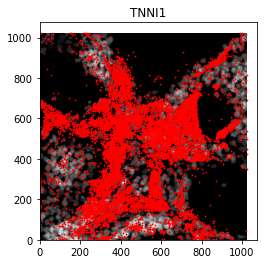

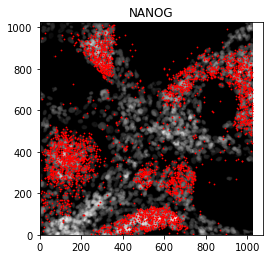

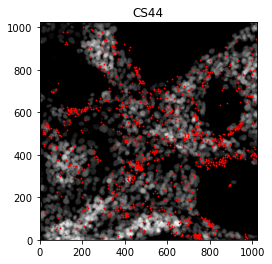

In [9]:
model.plot_gene(marker_genes,genes_list,figsize=(4,4),s=0.6)

### Pre-processing

In [10]:
### pct_filter: percent of spots filtered out
### default: filter 10% spots out
pct_filter=0
model.preprocess(pct_filter)

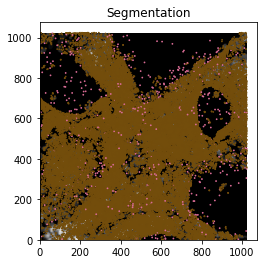

In [30]:
### plot preprocessing results
model.spots['is_noise']=model.spots['is_noise']+1
model.plot_segmentation(figsize=(4,4),s=0.6,method='is_noise',plot_dapi=True)
model.spots['is_noise']=model.spots['is_noise']-min(model.spots['is_noise'])-1

### Cell segmentation

In [31]:
%%time

### segmentation
model.min_spot_per_cell=5
model.segmentation(cell_num_threshold=0.01,dapi_grid_interval=4,add_dapi=True,use_genedis=True)

# res_over_dapi_erosion(self.spots, self.dapi_binary)

After denoising, mRNA spots: 54446
Computing NGC coordinates


54446it [00:00, 119826.63it/s]


After adding DAPI points, all spots:277976
DPC
  Compute spatial distance


277976it [00:02, 123833.07it/s]


  Compute genetic distance


277976it [00:05, 47949.08it/s]


  Compute density rho and the nearest distance


277976it [00:09, 29756.28it/s]
100%|██████████| 124/124 [00:01<00:00, 113.99it/s]


  Find cell number:1525.0


100%|██████████| 277976/277976 [00:00<00:00, 748428.31it/s]


Postprocessing
CPU times: user 1min 36s, sys: 6.94 s, total: 1min 43s
Wall time: 1min 46s


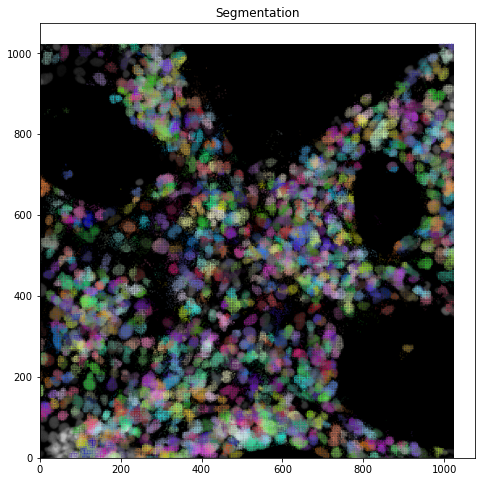

In [34]:
### plot cell segmentation results in spots (colored by cells)
model.plot_segmentation(figsize=(8,8),s=0.005,plot_with_dapi=True,plot_dapi=True, show=False)
plt.show()

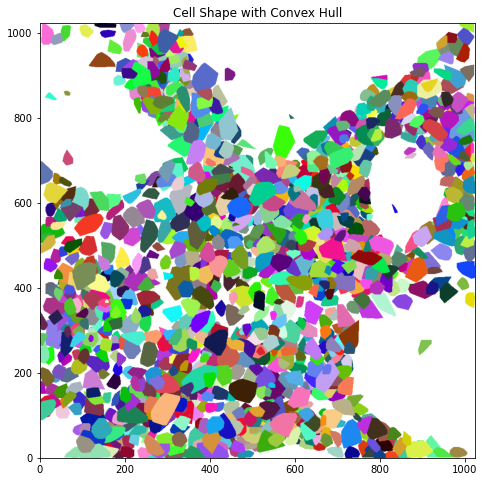

In [36]:
### plot cell segmentation results in convex hull
model.create_convex_hulls(figsize=(8,8),plot_with_dapi=True)

### Save cell segmentation results

In [37]:
path_save = filepath+'spots_all.csv'
model.save_segmentation(path_save)

In [38]:
np.savetxt(filepath+"cellcenter.csv",model.cellcenter,delimiter=",")

### Perform cell typing (based on Scanpy package)

In [6]:
path_save = filepath+'spots_all.csv'
savespots=pd.read_csv(path_save)
model.spots=savespots
model.cellcenter = np.genfromtxt(filepath+"cellcenter.csv", delimiter=',')

In [7]:
model.spots

,spot_location_1,spot_location_2,spot_location_3,gene,is_noise,clustermap
0,45,541,1,1,-1,-1.0
1,55,490,5,1,0,-1.0
2,85,495,5,1,0,200.0
3,236,893,2,1,0,1486.0
4,241,904,1,1,0,1486.0
...,...,...,...,...,...,...
55166,295,743,90,8,-1,-1.0
55167,829,672,88,8,-1,-1.0
55168,216,314,90,8,0,1001.0
55169,217,733,90,8,-1,-1.0


In [8]:
cellid='clustermap'
geneid='gene'
num_gene=np.max(spots['gene'])
gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)

cluster_method='aggre'

In [9]:
model.create_cell_adata(cellid,geneid,gene_list,genes,num_dims)

/Users/yichunhe/opt/anaconda3/envs/workEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


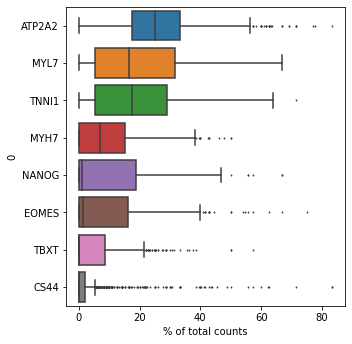

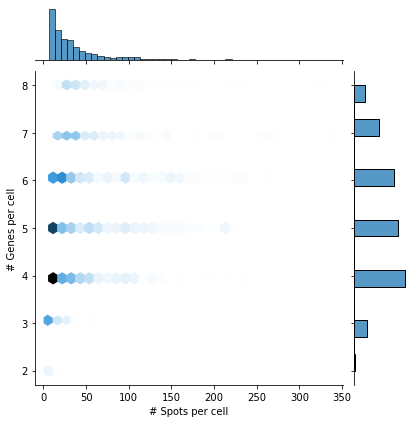

In [10]:
model.cell_typing(cluster_method=cluster_method)

/Users/yichunhe/opt/anaconda3/envs/workEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


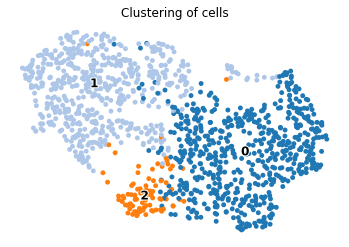

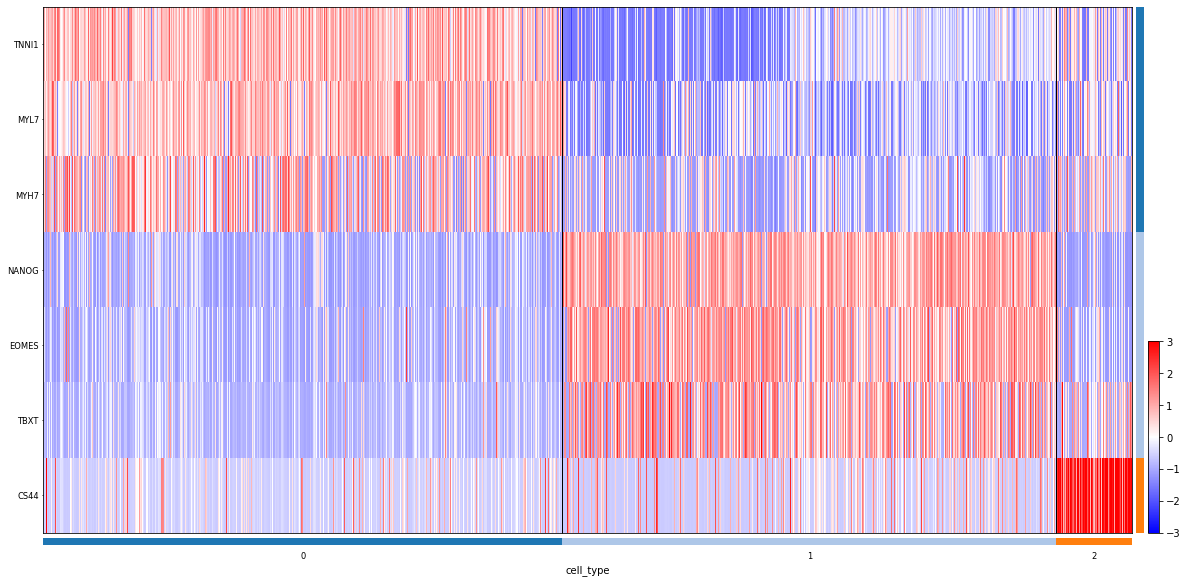

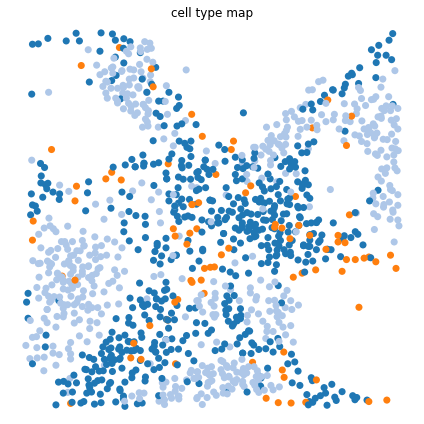

In [11]:
cluster_pl=model.plot_cell_typing()

In [13]:
model.map_cell_type_to_spots(cellid)

In [15]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d


In [17]:
img_res = np.zeros(self.dapi_stacked.shape)

for i in model.cellid_unique:
    print(i)

200.0
1486.0
379.0
324.0
1230.0
605.0
9.0
13.0
597.0
931.0
197.0
329.0
3.0
1202.0
1.0
607.0
606.0
228.0
962.0
336.0
1380.0
1247.0
59.0
204.0
1368.0
12.0
2.0
601.0
1017.0
344.0
1122.0
943.0
589.0
26.0
936.0
1375.0
240.0
1275.0
598.0
4.0
233.0
1135.0
221.0
625.0
1400.0
610.0
621.0
201.0
1343.0
940.0
464.0
946.0
5.0
1113.0
18.0
251.0
244.0
222.0
1414.0
604.0
10.0
656.0
11.0
1010.0
24.0
29.0
1114.0
1395.0
655.0
340.0
341.0
1294.0
16.0
594.0
346.0
348.0
674.0
14.0
337.0
32.0
626.0
1031.0
1124.0
351.0
1128.0
358.0
392.0
73.0
608.0
390.0
339.0
627.0
349.0
649.0
632.0
1062.0
696.0
1134.0
711.0
691.0
948.0
1234.0
1198.0
426.0
223.0
359.0
75.0
1371.0
700.0
1401.0
25.0
210.0
688.0
106.0
1506.0
15.0
1309.0
643.0
1221.0
1471.0
778.0
827.0
1378.0
446.0
957.0
1324.0
198.0
218.0
1417.0
1408.0
1125.0
17.0
402.0
63.0
28.0
1121.0
89.0
961.0
747.0
363.0
470.0
1034.0
27.0
388.0
657.0
666.0
85.0
1344.0
372.0
51.0
635.0
207.0
46.0
1301.0
645.0
360.0
1354.0
361.0
208.0
1419.0
500.0
1123.0
362.0
1189.0
370.0
3

In [ ]:
spots_portion = np.array(spots_repr[cell_ids==cell,:2])

In [21]:
model.spots.loc[model.spots['clustermap']==i,['spot_location_1',' ']]

,spot_location_1,spot_location_2,spot_location_3,gene,is_noise,clustermap,cell_type
49302,158,367,72,5,0,1335.0,1
49337,157,371,72,5,0,1335.0,1
49379,155,369,74,5,0,1335.0,1
49410,160,369,75,5,0,1335.0,1
52117,158,371,77,6,0,1335.0,1
55032,157,368,78,8,0,1335.0,1
